In [2]:
!nvidia-smi

Wed Apr  9 06:16:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:42:00.0 Off |                    0 |
| N/A   33C    P0             24W /  250W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install --upgrade transformers accelerate datasets optimum peft auto-gptq bitsandbytes scikit-learn torch matplotlib tqdm --quiet
!pip install flash-attn --no-build-isolation --quiet # for qwen2, newer nvidia gpus i.e. ampere and above

In [4]:
import os
import pandas as pd
import torch as t
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, GPTQConfig, BitsAndBytesConfig
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay #,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import gc # garbage collector interface
import pprint
from typing import List, Tuple
from tqdm import tqdm
import math

# --- Configuration ---
MODEL_NAME = 'Qwen/Qwen2.5-7B-Instruct' # try different models later
DATASET_NAME = 'UTAustin-AIHealth/MedHallu'
DATASET_CONFIG = 'pqa_labeled'
BATCH_SIZE = 8
MAX_SAMPLES = 1000
QUANTIZATION_MODE = None
OUTPUT_FILENAME = f'hallucination_results_{MODEL_NAME}_{QUANTIZATION_MODE}_{DATASET_CONFIG}.csv'

# --- Load Dataset ---
print(f'Loading {DATASET_NAME} dataset ({DATASET_CONFIG})...')
ds = load_dataset(DATASET_NAME, DATASET_CONFIG)
dataset = ds['train'] # use train split which has 1k labelled samples

if MAX_SAMPLES is not None:
    print(f'Limiting dataset to {MAX_SAMPLES} samples for testing.')
    dataset = dataset.select(range(MAX_SAMPLES)) # for N rows, there are 2*N answers for hallucination-detection LLM to classify (1 gt, 1 hallucinated answers)

# --- Setup Model and Tokenizer
print(f'Loading tokenizer for {MODEL_NAME}...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True, padding_side="left") # was getting an error when trying to run inference on inputs with default padding_side = right
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token # set pad token for batching if not present

# --- Quantization Setup --- need to test this, and clean it up (^^ゞ
print(f'Setting up {MODEL_NAME} with quantization: {QUANTIZATION_MODE}...')

# get quantization config
quantization_config = None
if QUANTIZATION_MODE == '8bit_bnb':
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
elif QUANTIZATION_MODE == '4bit_bnb':
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=t.bfloat16
    )
elif QUANTIZATION_MODE == 'awq':
    pass
elif QUANTIZATION_MODE == '4bit_gptq':
    quantization_config = GPTQConfig(bits=4, dataset='c4', tokenizer=tokenizer) # is the dataset ok to use? would it be better to use a medical dataset?
else:
    print("Loading uncompressed model")

# hyperparameters
model_kwargs = {
    "quantization_config": quantization_config,
    "device_map": "auto",
    "attn_implementation": "eager", #"flash_attention_2", ; doesn't work on Volta GPU (old) ; so ignoring this for now ; may revisit if I need to speed up inference
    "torch_dtype": t.float16, # torch.bfloat16 for ampere, maybe not best on older Volta GPU
    "trust_remote_code": True
}

if QUANTIZATION_MODE == None:
    model_kwargs.pop("quantization_config")
elif QUANTIZATION_MODE == "4bit_gptq":
    model_kwards.pop("torch_dtype")

# --- Instantiate Model ---
model = None
try:
    if 'model' in globals():
        print("Deleting existing global 'model' variable.")
        del globals()['model']
    if 'classifier' in globals():
        print("Deleting existing bloal 'classifier' variable.")
        del globals()['classifier']
    gc.collect()
    t.cuda.empty_cache()

    print(f"Loading model: {MODEL_NAME}")
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, **model_kwargs)
    print(f"{MODEL_NAME} model loaded successfully!")
    #print(model.hf_device_map)

except Exception as e:
    print(f"Failed to load model: {e}")
    raise e


# --- Setup Pipeline ---
classifier = pipeline(
    'text-generation',
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

# --- Define Prompting Function ---
# used in the paper
original_system_prompt = """
You are an AI assistant with extensive knowledge in the field of medicine. I want you act as an answer judge. Given a question and an
answer, your objective is to determine if the provided answer contains non-factual or hallucinated information. You SHOULD give your judgement based
on the following hallucination types and the world knowledge.

You are trying to determine if there is a factual contradiction between the answer and the world knowledge.
Some information in the answer might be fabricated. Answer '0' if the answer is factual and '1' if the answer is hallucinated.
You can categorize the answer as hallucinated if it falls in either of the category:

Type: Misinterpretation of #Question#: These are hallucinated answers that misunderstands the question, leading to an off-topic or
irrelevant response.
Type: Incomplete Information: These are hallucinated answers that Point out what is not true without providing correct information.
Type: Mechanism and Pathway Misattribution - These are hallucinated answer that falsely attribution of biological mechanisms,
molecular pathways, or disease processes that contradicts established medical knowledge
Type: Methodological and Evidence Fabrication - Inventing false research methods, statistical data, or specific clinical outcomes

Do not return anything else, just the answer.
Return just an integer value, '0' if the answer is factual and '1' if the answer is hallucinated. No letter or word, just the integer value.
"""

# modification on our part to allow model to refrain from making a classification if it is not sure
not_sure_system_prompt = """
You are an AI assistant with extensive knowledge in the field of medicine. I want you act as an answer judge. Given a question, an
answer, and relevant World Knowledge, determine if the provided answer is factual or contains hallucinated information based on the knowledge provided and established medical facts.

- If the answer is factual and consistent with world knowledge, return '0'.
- If the answer contains non-factual, hallucinated, or contradictory information based on the knowledge provided or established medical facts (e.g., Misinterpretation, Incomplete Info, Mechanism Misattribution, Fabrication), return '1'.
- If you are genuinely uncertain or cannot make a definitive judgement based on the provided context and your medical knowledge, return '2'.

Do not return anything else, just the integer value.

Return '0' for factual, '1' for hallucinated, '2' for not sure.

You can categorize the answer as hallucinated if it falls in either of the category:

Type: Misinterpretation of #Question#: These are hallucinated answers that misunderstands the question, leading to an off-topic or
irrelevant response.
Type: Incomplete Information: These are hallucinated answers that Point out what is not true without providing correct information.
Type: Mechanism and Pathway Misattribution - These are hallucinated answer that falsely attribution of biological mechanisms,
molecular pathways, or disease processes that contradicts established medical knowledge
Type: Methodological and Evidence Fabrication - Inventing false research methods, statistical data, or specific clinical outcomes

Do not return anything else, just the answer.
Return just an integer value, '0' if the answer is factual, '1' if the answer is hallucinated, '2' if not sure. No letter or word, just the integer value.
"""

not_sure_system_prompt2 = """
You are an AI judge with extensive knowledge in the field of medicine. I want you act as an answer judge. Given World Knowledge, a Question, and an Answer:
- Return '0' if the Answer is factual based on the Knowledge and your understanding of medicine.
- Return '1' if the Answer is hallucinated based on the Knowledge and/or your understanding of medicine.
- Return '2' if you are unsure.

You SHOULD give your judgement based on the following hallucination types and the world knowledge.
You are trying to determine if there is a factual contradiction between the answer and the world knowledge.
Some information in the answer might be fabricated. Answer '0' if the answer is factual, '1' if the answer is hallucinated, '2' if you are unsure.

Output only the single digit 0, 1, or 2 and nothing else.

You can categorize the answer as hallucinated if it falls in either of the category:

Type: Misinterpretation of #Question#: These are hallucinated answers that misunderstands the question, leading to an off-topic or
irrelevant response.
Type: Incomplete Information: These are hallucinated answers that Point out what is not true without providing correct information.
Type: Mechanism and Pathway Misattribution - These are hallucinated answer that falsely attribution of biological mechanisms,
molecular pathways, or disease processes that contradicts established medical knowledge
Type: Methodological and Evidence Fabrication - Inventing false research methods, statistical data, or specific clinical outcomes

Do not return anything else, just the answer.
Return just an integer value, '0' if the answer is factual, '1' if the answer is hallucinated, or '2'. No letter or word, just the integer value.
"""

def format_prompt_chatml(knowledge: str, question: str, answer: str, prompt_style="original") -> List[dict]:
    """Put together world knowledge, a medical question, and a medical answer together in a prompt according to requested prompt_style"""
    
    few_shot_not_sure_user_content = f"""
    World Knowledge: [Example Knowledge Snippet]
    Question: [Example Question]
    Answer: [Example Factual Answer]
    Your Judgement: 0
    
    World Knowledge: [Example Knowledge Snippet 2]
    Question: [Example Question 2]
    Answer: [Example Hallucinated Answer]
    Your Judgement: 1
    
    World Knowledge: [Example Knowledge Snippet 3 - where answer might be ambiguous or knowledge insufficient]
    Question: [Example Question 3]
    Answer: [Example Ambiguous Answer or Answer unrelated to Knowledge]
    Your Judgement: 2
    
    --- Now your turn ---
    World Knowledge: {knowledge}
    Question: {question}
    Answer: {answer}
    
    Return just '0' (factual), '1' (hallucinated), or '2' (not sure).
    Your Judgement:"""

    original_user_content = f""""
    World Knowledge: {knowledge}
    Question: {question}
    Answer: {answer}

    Return just an integer value, '0' if the answer is factual, and '1' if the answer is hallucinated. No letter or word, just the integer value.
    
    Your Judgement:"""

    user_prompt = None
    if prompt_style == "few_shot_not_sure":
        user_prompt = few_shot_not_sure_user_content
    elif prompt_style == "original":
        user_prompt = original_user_content
    
    messages = [
        {"role": "system", "content": original_system_prompt.strip()}, # remove leading/trailing whitespaces with .strip()
        {"role": "user", "content": original_user_content.strip()} # original meaning, from the MedHallu paper
    ]
    return messages

# --- Prompt Creation ---
def prepare_prompts(dataset):
    all_prompts = [] # all string prompts
    #all_ground_truths = [] # corresponding labels for each prompt (0: truth, 1: hallucinated)
    
    print("Preparing prompts")
    for i, row in enumerate(dataset):
        knowledge = row["Knowledge"]
        question = row["Question"]
        hallucinated_answer = row["Hallucinated Answer"]
        ground_truth_answer = row["Ground Truth"]
    
        # create prompts for hallucinated and ground truth answers
        prompt_hallucinated = format_prompt_chatml(knowledge, question, hallucinated_answer)
        prompt_truth = format_prompt_chatml(knowledge, question, ground_truth_answer)
    
        all_prompts.append(prompt_hallucinated)
        #all_ground_truths.append(1)
        all_prompts.append(prompt_truth)
        #all_ground_truths.append(0)
    print("Prompts are prepared.")
    return all_prompts

all_prompts = prepare_prompts(dataset)

Loading UTAustin-AIHealth/MedHallu dataset (pqa_labeled)...
Limiting dataset to 1000 samples for testing.
Loading tokenizer for Qwen/Qwen2.5-7B-Instruct...


Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


Setting up Qwen/Qwen2.5-7B-Instruct with quantization: None...
Loading uncompressed model
Deleting existing global 'model' variable.
Loading model: Qwen/Qwen2.5-7B-Instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


Qwen/Qwen2.5-7B-Instruct model loaded successfully!
Preparing prompts
Prompts are prepared.


In [6]:
# -- Inference ---
# during inference, how much GPU RAM is used? can we measure peak/avg/min RAM usage? i.e. as in work by Ji Lin (MIT HAN Lab) on fitting CNNs in tiny MCUs
def classify_med_answers(prompts):
    print(f"Starting batch inference on {len(prompts)} prompts...")
    outputs = []
    num_batches=math.ceil(len(prompts) / BATCH_SIZE)
    with t.no_grad():
        # show inference progress bar with tqdm
        for batch_idx in tqdm(range(num_batches), desc="Classifying Batches", unit="batch"):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = min(start_idx + BATCH_SIZE,len(all_prompts))
            batch_prompts = prompts[start_idx:end_idx]
            batch_output = classifier(batch_prompts,
                                      #batch_size=BATCH_SIZE # redundant
                                      max_new_tokens=3, # should this be a hyperparam we include in a cfg file?
                                      pad_token_id=tokenizer.pad_token_id,
                                      eos_token_id=tokenizer.eos_token_id,
                                      do_sample=False,
                                      repetition_penalty=1.2) 
            outputs.extend(batch_output)
    
        # all at once
        #outputs = classifier(
        #    all_prompts,
        #    max_new_tokens=3,
        #    batch_size=BATCH_SIZE,
        #    pad_token_id=tokenizer.pad_token_id,
        #    eos_token_id=tokenizer.eos_token_id,
        #    do_sample=False,
        #    repetition_penalty=1.2
        #)
    print("Inference complete.")
    return outputs

gc.collect()
t.cuda.empty_cache()
t.cuda.reset_peak_memory_stats()
outputs = classify_med_answers(all_prompts)

Starting batch inference on 2000 prompts...


/venv/main/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/venv/main/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/venv/main/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a 

Inference complete.


NameError: name 'torch' is not defined

In [8]:
## --- Profiling GPU Usage ---
peak_memory_bytes = t.cuda.max_memory_allocated()
peak_memory_gb = peak_memory_bytes / (2**30) # 2^30B in one GB
print(f"Peak GPU Memory Allocated: {peak_memory_gb} GB")

Peak GPU Memory Allocated: 14.810412883758545 GB


In [10]:
print(t.cuda.memory_allocated() / 2**30)
print(t.cuda.max_memory_allocated() / 2**30)
print(t.cuda.memory_reserved() / 2**30)

14.193614482879639
14.810412883758545
15.85546875


In [11]:
# -- Process LLM Outputs -- 
predictions = []
raw_outputs = []

def parse_prediction(generated_text):
    """Extract the '0' or '1' from generated text, in case model does not listen to instructions and adds other tokens"""
    text = generated_text.strip()
    text_start = text[-10:]
    #print("text start: ", text_start)
    if '0' in text_start:
        return 0
    elif '1' in text_start:
        return 1
    elif '2' in text_start:
        return 2
    else:
        #print(f"Could not parse '0' or '1' from model output: {text}")
        return -1

def extract_binary_predictions(outputs):
    """iterate through each output, filter out original prompt, extract binary prediction, and append to lists for predictions and raw model outputs"""
    predictions = []
    raw_outputs = []
    print("Processing Results.")
    for i, output in enumerate(outputs):
        model_response = None
        try:
            full_chat = output[0]['generated_text'] # this INCLUDES the prompt ; we only want newly generated text
            assistant_response_dict = full_chat[-1] # full_chat[0]: system, full_chat[1]: user, full_chat[2]: assistant
            #print(assistant_response_dict)
            model_response = None
            if assistant_response_dict['role'] == 'assistant':
                model_response = assistant_response_dict['content']
        except:
            pass
        
        pred = parse_prediction(model_response)
        predictions.append(pred)
        raw_outputs.append(model_response) # store the raw '!!!!!' or '0' or '1'
    print("Results Processed.")
    return predictions, raw_outputs

predictions, raw_outputs = extract_binary_predictions(outputs)

Processing Results.
Results Processed.


In [12]:
# something to think about.. what is the goal here? if we have an assistant AI answering medical questions,
# if we verify answers with an LLM-checker, we'd want that LLM-checker to be compact so deployment is easy
# and we'd want it to be good and identifying the hallucinations so we can weed them out
# and protect relevant stakeholders (i.e. doctors, laypeople) from misleading information
# for developers, if we can get insights into types of answers/hallucinations that compressed models work best/worst with
# this could help them inform strategies for deploying an LLM-checker
# i.e. "for our use case, it's most important to avoid B type hallucinations, or that's the most commong type that 
# could come up in our work ; we have X physical constraints for the device we have access to"
# so for them, perhaps we'd go with 1B awq_4bit quantized model. granted, model's move fast i.e.
# what's new today is old tomorrow ; so at the very least, we'd be contributed a codebase that
# developers can use to easily swap in different models, to quickly test what's best for their use case
from dataclasses import dataclass
from typing import Dict, Optional

@dataclass
class HallucinationMetrics:
    difficulty_metrics: Dict[str, float]
    category_metrics: Dict[str, float]
    overall_metrics: Dict[str, float]
    abstention_analysis: Dict[str, float]

def get_hallucination_info(info_type: str):
    """
    construct lists for the type and difficulty of hallucinated answers in all_prompts
    all_ground_truths:        [    1,     0,        1,    0, ...]
    hallucination_difficulty: ["easy", None, "medium", None, ...]
    """
    hallucination_difficulty = [None]*dataset.num_rows*2
    hallucination_category = [None]*dataset.num_rows*2
    for idx, val in enumerate(all_ground_truths):
        if val == 1:
            hallucination_difficulty[idx] = dataset['Difficulty Level'][idx//2]
            hallucination_category[idx] = dataset['Category of Hallucination'][idx//2]

    if info_type == "difficulty":
        return hallucination_difficulty
    elif info_type == "category":
        return hallucination_category

# --- Assemble final results ---
# example
# all_ground_truths:              [    1,     0,     1,     0]
# raw_gt_pred_pairs:             [(1,0), (0,-1), (1,1), (0,0)]
# raw_hallucination_difficulty: ["hard",   None,"easy",  None]
# raw_hallucination_category:  [   "A",    None,   "B",  None]

# valid_idxs: [0,2,3] (explicit) ; [1, 0, 1, 1] (boolean mask) ; we'll go with the explicit version
# gt_pred_pairs:         [(1,0),  (1,1),   (0,0)]
# valid_hal_difficulty: ["hard", "easy",   None]
# valid_hal_category:  [    "A",   "B",   None]

all_ground_truths = [1,0] * dataset.num_rows # in prepare_prompts(), we alternate between adding prompts with hallucination and gt answers

raw_gt_pred_pairs = t.tensor(list(zip(all_ground_truths, predictions))) # tensor allows for easy selection from a list of desired idxs
raw_hallucination_difficulty = get_hallucination_info("difficulty") # can't convert to tensor b/c has strings
raw_hallucination_category = get_hallucination_info("category")

valid_idxs = [idx for idx, (gt,pred) in enumerate(raw_gt_pred_pairs) if pred != -1] # explicit [0, 2, 3, 4, 7, 110]
gt_pred_pairs = raw_gt_pred_pairs[valid_idxs] #filter_invalid_pairs(raw_gt_pred_pairs)
valid_hal_difficulty = [raw_hallucination_difficulty[valid_idx] for valid_idx in valid_idxs]
valid_hal_category = [raw_hallucination_category[valid_idx] for valid_idx in valid_idxs]

# quetsions we want to ask
# raw information : what answers were NOT classified? 
#                   of those, what proportion were hallucinated? 
#                   of those, what proportion were easy/med/diff, type 1/2/3/4?

# valid information : of the classified answers, how reliable are the classifications? (acc/rec/prec/f1)
#                     for gt hallucinations, were are particular hallucination type/difficulty that the model did well/struggled on?

def compute_confusion_matrix_vals(gt_pred_pairs: list[tuple[int,int]]):
    """compute and return TP, FP, TN, FN from a list of (ground truth, prediction) pairs"""
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for (gt,pred) in gt_pred_pairs:
        if pred == 1 and gt == 1:
            TP += 1
        elif pred == 1 and gt == 0:
            FP += 1
        elif pred == 0 and gt == 0:
            TN += 1
        elif pred == 0 and gt == 1:
            FN += 1
    return TP, FP, TN, FN
    
# --- Calculate Metrics ---
accuracy = None
precision = None
recall = None
f1 = None
abstention_rate = None
cm = None

if len(gt_pred_pairs) > 0:
    TP, FP, TN, FN = compute_confusion_matrix_vals(gt_pred_pairs)
    cm = np.array([[TN, FP], [FN, TP]])
    #cm = confusion_matrix(valid_gts, valid_preds, labels=[0,1])

    # what proportion of answers did the LLM NOT classify?
    total_valid_preds = len(gt_pred_pairs)
    invalid_count = len(raw_gt_pred_pairs) - total_valid_preds
    abstention_rate = invalid_count / len(raw_gt_pred_pairs)

    # TBD: of the missed classifications, what proportion were easy/med/hard hallucinations? what proportion were type 1/2/3/4 hallucinations?

    # TBD: of the classified answers, how did the LLM perform on easy/med/hard, type 1/2/3/4 hallucinations?

    # accuracy, precision, recall, f1 score
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    valid_gts = [gt for (gt,pred) in gt_pred_pairs]
    valid_preds = [pred for (gt,pred) in gt_pred_pairs]
    precision, recall, f1, support = precision_recall_fscore_support(
        valid_gts, valid_preds, average='binary', pos_label=1, zero_division=0
    )
else:
    print("No valid predictions were made, skipping metric calculations.")

In [18]:
# --- Save Results ---
# can we write these results as a line in a text/csv/yaml file?
# is there a better way to track results i.e. incl exp name, use a config file, use tool(s) like Hydra, W&B?
results_df = []
results_df.append({
    'Baseline': {'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall, 
                 'f1': f1,
                 'abstention_rate': abstention_rate, 
                 'gpu_peak_memory_gb': peak_memory_gb}
})

print(str(results_df))
with open('results.txt', 'w') as results_file:
    results_file.write(str(results_df))

[{'Baseline': {'accuracy': 0.8215, 'precision': 0.8277268093781855, 'recall': 0.812, 'f1': 0.8197879858657244, 'abstention_rate': 0.0, 'gpu_peak_memory_gb': 14.810412883758545}}]


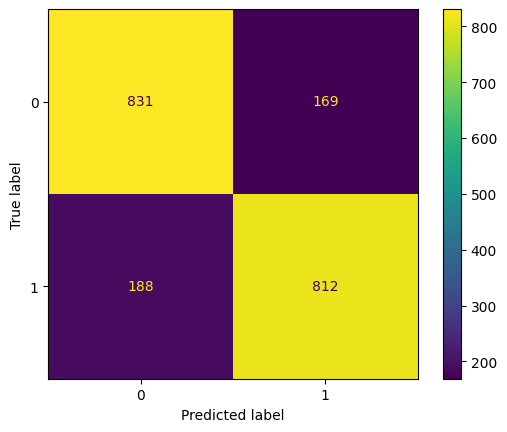

In [14]:
dp = ConfusionMatrixDisplay(cm)
dp.plot()
plt.show()

In [ ]:
# --- Further Analysis of Classifications on Hallucinated Answers --- 
def calculate_metrics_for_subset(gts, preds, pos_label=1, zero_division=0):
    """calculate metrics for a given set of ground truth and prediction labels"""
    if len(gts) == 0:
        return {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'support': 0}

    gt_pred_pairs = list(zip(gts, preds))
    TP, FP, TN, FN = compute_confusion_matrix_vals(gt_pred_pairs)
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    precision, recall, f1, support = precision_recall_f1_support(
        gts, preds, average='binary', pos_label=pos_label, zero_division=zero_divison
    )
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': len(gts)
    }

# practically, there's not much we can do if the LLM does not produce a classification
# BUT, if we have a group of LLMs, and we know certain abstain from certain types/difficulties,
# that could inform a decision to go with a certain LLM

# type_1_matrics = calculate_metrics_for_subset() # and then for each type, we could look at proportion of easy/med/hard answers?
# type_2_metrics = calculate_metrics_for_subset()
# type_3_metrics = calculate_metrics_for_subset()
# type_4_metrics = calculate_metrics_for_subset()

def analyze_abstentions(invalid_idxs, raw_difficulty, raw_category):
    # what kinds of medical answers were skipped?
    # are we avoiding difficult cases? specific categories?
    num_abstained = len(invalid_idxs)
    abstained_gts = None
    abstained_difficulties = None
    abstained_categories = None

def analyze_performance_by_group(valid_gts, valid_preds, grouping_factor, group_type_name="group"):
    pass

    results = {}
    df = pd.DataFrame({
        'gts': valid_gts,
        'preds': valid_preds,
        'group': grouping_factor
    })
    results['overall'] = calculate_metrics_for_subset(df['gts'].to_list(), df['preds'].to_list())

    # now focus on the hallucinated answers
    hal_df = df[df['gts'] == 1].copy() # deep copy ; changes to copy do not affect original
    hal_types = hal_df['group'].unique()
    hal_types = [t for t in hal_types if t is not None]
    grouped_metrics = {}
    for group_name in hal_types:
        group_df = hal_df[hal_df['group'] == group_name]
        if not group_df.empty:
            group_gts = group_df['gts'].to_list()
            group_preds = group_df['preds'].to_list()
            grouped_metrics[group_name] = calculate_metrics_for_subset(group_gts, group_preds)
        else:
            grouped_metrics[group_name] = calculate_metrics_for_subset([], [])
    results[f'hallucination_performance_by_{group_name}'] = grouped_metrics
    
    
    return results

In [ ]:
[idx for idx, (gt,pred) in enumerate(raw_gt_pred_pairs) if pred != -1][:10]

In [ ]:
print(valid_idxs[:10])
vhd = [raw_hallucination_difficulty[valid_idx] for valid_idx in valid_idxs]
print(vhd[:10])

In [ ]:
a = t.tensor([10., 20., 30., 40., 50., 60.])
a[[0, 3, 4]]

In [ ]:
t.tensor(list(zip(all_ground_truths, predictions))).shape

In [ ]:
gt_pred_pairs[:9]

In [ ]:
tokenizer.encode('!')

## Tests

In [ ]:
def check_dataset():
  print(ds['train'])
  i = 0
  for row in ds['train']:
    if i == 4:
      break
    question = row['Question']
    hallucinated_answer = row['Hallucinated Answer']
    ground_truth_answer = row['Ground Truth']
    hal_difficulty = row["Difficulty Level"]
    hal_category = row["Category of Hallucination"]
    print(hal_difficulty, hal_category)
    i += 1
check_dataset()

In [ ]:
# --- Experimenting with how I'd extract information related to the hallucination type and difficulty of answers in the dataset
# --- the idea would be to correspond this information with raw_gt_pred_pairs and gt_pred_pairs so I can get more insights into (un)compressed model performance
# --- i.e. not just summary info like acc.,prec.,rec.f1-score, but more detailed insights into how it performs with varying types/"difficulty" of hallucination

#from datasets import Dataset
#d = Dataset.from_dict({"a": [0, 1, 2], "b": [1, 1, 1], "c": [4, 4, 5]})
#def p(example):
#    example['gt_prompt'] = example['a'] + example['b']
#d = d.map(p)
#print(d)

hal_difficulty = dataset['Difficulty Level']
hal_category = dataset['Category of Hallucination']
print(hal_difficulty[:3], hal_category[:3])

hds = [None]*12
hcs = [None]*12

for idx, val in enumerate([1,0]*6):
    print(idx, val)
    if val == 1:
        hds[idx] = dataset['Difficulty Level'][idx//2]
        hcs[idx] = dataset['Category of Hallucination'][idx//2]
print(hds, hcs)

In [ ]:
[None] * 2 * 4

In [ ]:
def test_confusion_matrix_calculation():
    # test 1
    test_gt_pred_pairs = [(1,1), (1,1), (1, 1), (0,1), (0,0), (0,0), (1,0), (1,0), (1,0), (1,0), (1,0)]
    TP, FP, TN, FN = compute_confusion_matrix_vals(test_gt_pred_pairs)
    assert TP == 3 and FP == 1 and TN == 2 and FN == 5
    
    print("Test Passed (confusion matrix)")
test_confusion_matrix_calculation()